# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

random.seed(42)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]

        '''self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)'''

        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1).float()

        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        '''return image, num_pieces.float()'''
        return image, num_pieces.unsqueeze(0)

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 1
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [5]:
import time
start = time.time()
for i, batch in enumerate(train_dataloader):
    print(f"Batch {i} loaded in {time.time() - start:.2f} seconds")
    if i >= 5:
        break
    start = time.time()

Batch 0 loaded in 0.12 seconds
Batch 1 loaded in 0.09 seconds
Batch 2 loaded in 0.10 seconds
Batch 3 loaded in 0.09 seconds
Batch 4 loaded in 0.09 seconds
Batch 5 loaded in 0.10 seconds


torch.Size([1, 224, 224, 3])
torch.Size([1, 1])
tensor(1)


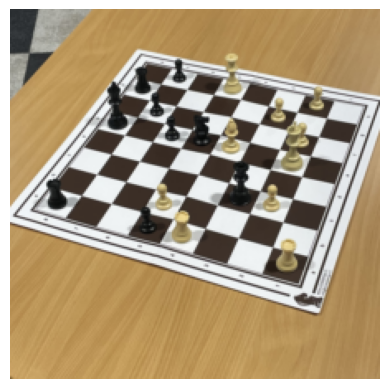

In [6]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [7]:
'''# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# Replace final classification layer (default is 1000 for ImageNet)
# You want 32 outputs — one for each possible number of pieces on the board (1 to 32)
model.fc = nn.Linear(model.fc.in_features, 32)

# Move model to device
model.to(device)'''


'# Get device\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nprint(f"Using {device} device")\n\n# Load pretrained ResNet-50\nmodel = models.resnet50(pretrained=True)\n\n# Replace final classification layer (default is 1000 for ImageNet)\n# You want 32 outputs — one for each possible number of pieces on the board (1 to 32)\nmodel.fc = nn.Linear(model.fc.in_features, 32)\n\n# Move model to device\nmodel.to(device)'

## Train the model

Define function to perform one iteration

In [8]:
'''def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    images = images.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return loss.item(), outputs'''

'def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):\n    if is_train:\n        model.train()\n    else:\n        model.eval()\n\n    images = images.to(device)\n    labels = labels.to(device)\n\n    with torch.set_grad_enabled(is_train):\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n\n        if is_train:\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n\n    return loss.item(), outputs'

Define function to train a model

In [9]:
'''def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_acc = 0.0
    best_model_path = 'best_model.pth'

    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Treino
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)
            running_loss += loss * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(labels, dim=1).to(device)
            correct_preds += (preds == true_labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            train_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

        train_history['loss'].append(avg_loss)
        train_history['accuracy'].append(avg_acc)
        print(f"✔️ Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}")

        # Validação
        if val_loader:
            running_loss = 0.0
            correct_preds = 0
            total_samples = 0
            val_bar = tqdm(val_loader, desc="Validation", leave=False)

            for images, labels in val_bar:
                loss, outputs = train_one_iteration(model, images, labels, optimizer=None, criterion=criterion, device=device, is_train=False)
                running_loss += loss * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                true_labels = torch.argmax(labels, dim=1).to(device)
                correct_preds += (preds == true_labels).sum().item()
                total_samples += labels.size(0)

                avg_loss = running_loss / total_samples
                avg_acc = correct_preds / total_samples
                val_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

            val_loss = running_loss / total_samples
            val_acc = correct_preds / total_samples
            val_history['loss'].append(val_loss)
            val_history['accuracy'].append(val_acc)
            print(f"🔍 Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Best model saved with accuracy: {best_val_acc:.4f}")

    return train_history, val_history'''

'def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):\n    best_val_acc = 0.0\n    best_model_path = \'best_model.pth\'\n\n    train_history = {\'loss\': [], \'accuracy\': []}\n    val_history = {\'loss\': [], \'accuracy\': []}\n\n    for epoch in range(num_epochs):\n        print(f"\nEpoch {epoch+1}/{num_epochs}")\n\n        # Treino\n        running_loss = 0.0\n        correct_preds = 0\n        total_samples = 0\n        train_bar = tqdm(train_loader, desc="Training", leave=False)\n\n        for images, labels in train_bar:\n            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)\n            running_loss += loss * images.size(0)\n\n            preds = torch.argmax(outputs, dim=1)\n            true_labels = torch.argmax(labels, dim=1).to(device)\n            correct_preds += (preds == true_labels).sum().item()\n            total_samples += labels.size(0)\n\n            avg_loss = ru

Define loss, optimizer and train the model

In [10]:
'''# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 2

# Train the model
train_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)
'''

'# Define loss function\nloss_fn = nn.CrossEntropyLoss()\n\n# Define optimizer\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\n# Number of epochs\nnum_epochs = 2\n\n# Train the model\ntrain_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)\n'

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [11]:
'''def plot_training_history(train_history, val_history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['accuracy'], label='Train Accuracy')
    plt.plot(val_history['accuracy'], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()'''

"def plot_training_history(train_history, val_history):\n    plt.figure(figsize=(12,5))\n\n    plt.subplot(1, 2, 1)\n    plt.plot(train_history['loss'], label='Train Loss')\n    plt.plot(val_history['loss'], label='Val Loss')\n    plt.title('Loss over epochs')\n    plt.xlabel('Epoch')\n    plt.ylabel('Loss')\n    plt.legend()\n\n    plt.subplot(1, 2, 2)\n    plt.plot(train_history['accuracy'], label='Train Accuracy')\n    plt.plot(val_history['accuracy'], label='Val Accuracy')\n    plt.title('Accuracy over epochs')\n    plt.xlabel('Epoch')\n    plt.ylabel('Accuracy')\n    plt.legend()\n\n    plt.tight_layout()\n    plt.show()"

In [12]:
'''plot_training_history(train_history, val_history)'''

'plot_training_history(train_history, val_history)'

## Test the model

Evaluate the model in the test set

In [13]:
'''def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
'''

'def test_model(model, test_loader, criterion, device):\n    model.eval()\n    running_loss = 0.0\n    correct_preds = 0\n    total_samples = 0\n\n    test_bar = tqdm(test_loader, desc="Testing")\n\n    with torch.no_grad():\n        for images, labels in test_bar:\n            images = images.to(device)\n            labels = torch.argmax(labels, dim=1).to(device)\n\n            outputs = model(images)\n            loss = criterion(outputs, labels)\n\n            running_loss += loss.item() * images.size(0)\n            _, preds = torch.max(outputs, 1)\n            correct_preds += (preds == labels).sum().item()\n            total_samples += labels.size(0)\n\n            avg_loss = running_loss / total_samples\n            avg_acc = correct_preds / total_samples\n            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)\n\n    test_loss = running_loss / total_samples\n    test_acc = correct_preds / total_samples\n\n    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:

In [14]:
'''def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")'''

'def load_model(model, model_path, device):\n    model.load_state_dict(torch.load(model_path, map_location=device))\n    model.to(device)\n    model.eval()\n    print(f"Loaded model from {model_path}")'

In [15]:
'''def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

# Exemplo de uso:

best_model_path = 'best_model.pth'  # caminho para o melhor modelo guardado

# Carrega o modelo antes do teste
load_model(model, best_model_path, device)

# Avalia no conjunto de teste
test_loss, test_acc = test_model(model, test_dataloader, loss_fn, device)'''

'def test_model(model, test_loader, criterion, device):\n    model.eval()\n    running_loss = 0.0\n    correct_preds = 0\n    total_samples = 0\n\n    test_bar = tqdm(test_loader, desc="Testing")\n\n    with torch.no_grad():\n        for images, labels in test_bar:\n            images = images.to(device)\n            labels = torch.argmax(labels, dim=1).to(device)\n\n            outputs = model(images)\n            loss = criterion(outputs, labels)\n\n            running_loss += loss.item() * images.size(0)\n            _, preds = torch.max(outputs, 1)\n            correct_preds += (preds == labels).sum().item()\n            total_samples += labels.size(0)\n\n            avg_loss = running_loss / total_samples\n            avg_acc = correct_preds / total_samples\n            test_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)\n\n    test_loss = running_loss / total_samples\n    test_acc = correct_preds / total_samples\n\n    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# **Now trying new approach with a different model**



## Defining the model

We will use a pre-trained ResNet50 network.

In [16]:
from torchvision.models import efficientnet_b0

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load pretrained EfficientNet-B0
model = efficientnet_b0(pretrained=True)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Move model to device
model.to(device)


Using cuda device


c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Train the model

Define function to perform one iteration

In [17]:
def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    images = images.to(device)
    labels = labels.to(device).float().unsqueeze(1)

    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return loss.item(), outputs

Define function to train a model

In [18]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'

    train_history = {'loss': [], 'mae': []}
    val_history = {'loss': [], 'mae': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        running_loss = 0.0
        running_mae = 0.0
        total_samples = 0
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)

            mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))

            running_loss += loss * images.size(0)
            running_mae += mae.item() * images.size(0)
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_mae = running_mae / total_samples
            train_bar.set_postfix(loss=avg_loss, MAE=avg_mae)

        train_history['loss'].append(avg_loss)
        train_history['mae'].append(avg_mae)
        print(f"✔️ Train Loss: {avg_loss:.4f} | Train MAE: {avg_mae:.4f}")

        if val_loader:
            running_val_loss = 0.0
            running_val_mae = 0.0
            total_val_samples = 0
            val_bar = tqdm(val_loader, desc="Validation", leave=False)

            for images, labels in val_bar:
                loss, outputs = train_one_iteration(model, images, labels, optimizer=None, criterion=criterion, device=device, is_train=False)

                mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))

                running_val_loss += loss * images.size(0)
                running_val_mae += mae.item() * images.size(0)
                total_val_samples += labels.size(0)

                avg_val_loss = running_val_loss / total_val_samples
                avg_val_mae = running_val_mae / total_val_samples
                val_bar.set_postfix(loss=avg_val_loss, MAE=avg_val_mae)

            val_history['loss'].append(avg_val_loss)
            val_history['mae'].append(avg_val_mae)
            print(f"🔍 Validation Loss: {avg_val_loss:.4f} | Validation MAE: {avg_val_mae:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Best model saved with val loss: {best_val_loss:.4f}")

    return train_history, val_history


Define loss, optimizer and train the model

In [19]:
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[1].parameters():
    param.requires_grad = True

model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3)

num_epochs = 10
train_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50

train_history_finetune, val_history_finetune = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)


Epoch 1/10


Training:   0%|          | 0/1442 [00:00<?, ?it/s]c:\Users\diogo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\diogo\AppData\Local\Temp\ipykernel_14464\581728217.py:19: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))


✔️ Train Loss: 66.0733 | Train MAE: 6.8585


Validation:   0%|          | 0/330 [00:00<?, ?it/s]C:\Users\diogo\AppData\Local\Temp\ipykernel_14464\581728217.py:42: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))


🔍 Validation Loss: 226.7488 | Validation MAE: 12.6653
💾 Best model saved with val loss: 226.7488

Epoch 2/10


✔️ Train Loss: 52.9076 | Train MAE: 6.3834


🔍 Validation Loss: 220.3210 | Validation MAE: 12.3416
💾 Best model saved with val loss: 220.3210

Epoch 3/10


✔️ Train Loss: 51.3688 | Train MAE: 6.2908


🔍 Validation Loss: 250.0647 | Validation MAE: 13.3509

Epoch 4/10


✔️ Train Loss: 51.0588 | Train MAE: 6.2718


🔍 Validation Loss: 208.1249 | Validation MAE: 11.9791
💾 Best model saved with val loss: 208.1249

Epoch 5/10


✔️ Train Loss: 49.4759 | Train MAE: 6.1746


🔍 Validation Loss: 234.3281 | Validation MAE: 12.8326

Epoch 6/10


✔️ Train Loss: 48.8334 | Train MAE: 6.1236


🔍 Validation Loss: 257.2375 | Validation MAE: 13.6800

Epoch 7/10


✔️ Train Loss: 47.2157 | Train MAE: 6.0012


🔍 Validation Loss: 273.1870 | Validation MAE: 14.2576

Epoch 8/10


✔️ Train Loss: 46.5535 | Train MAE: 5.9634


🔍 Validation Loss: 260.8871 | Validation MAE: 13.8133

Epoch 9/10


✔️ Train Loss: 46.3726 | Train MAE: 5.9536


🔍 Validation Loss: 291.3132 | Validation MAE: 14.8194

Epoch 10/10


✔️ Train Loss: 45.0797 | Train MAE: 5.8488


🔍 Validation Loss: 301.4819 | Validation MAE: 15.1132

Epoch 1/50


✔️ Train Loss: 14.8821 | Train MAE: 2.9800


🔍 Validation Loss: 239.5657 | Validation MAE: 13.9134
💾 Best model saved with val loss: 239.5657

Epoch 2/50


✔️ Train Loss: 4.8786 | Train MAE: 1.7405


🔍 Validation Loss: 189.6529 | Validation MAE: 11.8727
💾 Best model saved with val loss: 189.6529

Epoch 3/50


✔️ Train Loss: 3.7459 | Train MAE: 1.5458


🔍 Validation Loss: 161.6313 | Validation MAE: 11.1039
💾 Best model saved with val loss: 161.6313

Epoch 4/50


✔️ Train Loss: 3.1879 | Train MAE: 1.4206


🔍 Validation Loss: 229.3073 | Validation MAE: 13.5480

Epoch 5/50


✔️ Train Loss: 2.8421 | Train MAE: 1.3374


🔍 Validation Loss: 270.2293 | Validation MAE: 15.0350

Epoch 6/50


✔️ Train Loss: 2.8822 | Train MAE: 1.3418


🔍 Validation Loss: 176.0113 | Validation MAE: 11.8133

Epoch 7/50


✔️ Train Loss: 2.8053 | Train MAE: 1.3264


🔍 Validation Loss: 145.8919 | Validation MAE: 10.5190
💾 Best model saved with val loss: 145.8919

Epoch 8/50


✔️ Train Loss: 2.2729 | Train MAE: 1.1959


🔍 Validation Loss: 162.4719 | Validation MAE: 11.0822

Epoch 9/50


✔️ Train Loss: 2.0596 | Train MAE: 1.1417


🔍 Validation Loss: 235.0619 | Validation MAE: 13.8900

Epoch 10/50


✔️ Train Loss: 1.9228 | Train MAE: 1.1095


🔍 Validation Loss: 146.4828 | Validation MAE: 10.5702

Epoch 11/50


✔️ Train Loss: 1.6081 | Train MAE: 1.0112


🔍 Validation Loss: 187.8103 | Validation MAE: 12.2900

Epoch 12/50


✔️ Train Loss: 1.7963 | Train MAE: 1.0635


🔍 Validation Loss: 156.7428 | Validation MAE: 11.3632

Epoch 13/50


✔️ Train Loss: 1.6195 | Train MAE: 1.0270


🔍 Validation Loss: 236.8115 | Validation MAE: 14.2825

Epoch 14/50


✔️ Train Loss: 1.3907 | Train MAE: 0.9253


🔍 Validation Loss: 117.0723 | Validation MAE: 9.3484
💾 Best model saved with val loss: 117.0723

Epoch 15/50


✔️ Train Loss: 1.3877 | Train MAE: 0.9277


🔍 Validation Loss: 186.1169 | Validation MAE: 12.6007

Epoch 16/50


✔️ Train Loss: 1.2782 | Train MAE: 0.8895


🔍 Validation Loss: 117.9415 | Validation MAE: 9.4570

Epoch 17/50


✔️ Train Loss: 1.1418 | Train MAE: 0.8529


🔍 Validation Loss: 201.7357 | Validation MAE: 12.9286

Epoch 18/50


✔️ Train Loss: 1.2040 | Train MAE: 0.8623


🔍 Validation Loss: 106.3344 | Validation MAE: 9.0536
💾 Best model saved with val loss: 106.3344

Epoch 19/50


✔️ Train Loss: 1.1061 | Train MAE: 0.8295


🔍 Validation Loss: 97.1520 | Validation MAE: 8.4837
💾 Best model saved with val loss: 97.1520

Epoch 20/50


✔️ Train Loss: 0.9472 | Train MAE: 0.7603


🔍 Validation Loss: 86.7668 | Validation MAE: 8.1642
💾 Best model saved with val loss: 86.7668

Epoch 21/50


✔️ Train Loss: 1.0294 | Train MAE: 0.8034


🔍 Validation Loss: 107.8652 | Validation MAE: 9.3051

Epoch 22/50


✔️ Train Loss: 1.0283 | Train MAE: 0.8081


🔍 Validation Loss: 115.9991 | Validation MAE: 9.8581

Epoch 23/50


✔️ Train Loss: 0.9609 | Train MAE: 0.7721


🔍 Validation Loss: 130.0002 | Validation MAE: 10.5695

Epoch 24/50


✔️ Train Loss: 0.8759 | Train MAE: 0.7353


🔍 Validation Loss: 118.9533 | Validation MAE: 9.9104

Epoch 25/50


✔️ Train Loss: 0.8789 | Train MAE: 0.7418


🔍 Validation Loss: 169.1766 | Validation MAE: 12.1251

Epoch 26/50


✔️ Train Loss: 0.8929 | Train MAE: 0.7514


🔍 Validation Loss: 76.8036 | Validation MAE: 7.8711
💾 Best model saved with val loss: 76.8036

Epoch 27/50


✔️ Train Loss: 0.8093 | Train MAE: 0.7108


🔍 Validation Loss: 106.0520 | Validation MAE: 9.4705

Epoch 28/50


✔️ Train Loss: 0.8002 | Train MAE: 0.7084


🔍 Validation Loss: 76.0968 | Validation MAE: 7.8133
💾 Best model saved with val loss: 76.0968

Epoch 29/50


✔️ Train Loss: 0.7497 | Train MAE: 0.6903


🔍 Validation Loss: 93.6113 | Validation MAE: 8.6884

Epoch 30/50


✔️ Train Loss: 0.8005 | Train MAE: 0.7135


🔍 Validation Loss: 80.8463 | Validation MAE: 8.1044

Epoch 31/50


✔️ Train Loss: 0.7410 | Train MAE: 0.6831


🔍 Validation Loss: 80.6763 | Validation MAE: 8.1550

Epoch 32/50


✔️ Train Loss: 0.7105 | Train MAE: 0.6662


🔍 Validation Loss: 121.7942 | Validation MAE: 9.9766

Epoch 33/50


✔️ Train Loss: 0.7028 | Train MAE: 0.6652


🔍 Validation Loss: 61.8673 | Validation MAE: 6.8730
💾 Best model saved with val loss: 61.8673

Epoch 34/50


✔️ Train Loss: 0.6612 | Train MAE: 0.6415


🔍 Validation Loss: 78.5550 | Validation MAE: 7.9352

Epoch 35/50


✔️ Train Loss: 0.6378 | Train MAE: 0.6306


🔍 Validation Loss: 104.1091 | Validation MAE: 9.3309

Epoch 36/50


✔️ Train Loss: 0.6125 | Train MAE: 0.6207


🔍 Validation Loss: 80.5020 | Validation MAE: 7.9103

Epoch 37/50


✔️ Train Loss: 0.6769 | Train MAE: 0.6565


🔍 Validation Loss: 46.7970 | Validation MAE: 6.0150
💾 Best model saved with val loss: 46.7970

Epoch 38/50


✔️ Train Loss: 0.6179 | Train MAE: 0.6237


🔍 Validation Loss: 76.2799 | Validation MAE: 7.5509

Epoch 39/50


✔️ Train Loss: 0.6047 | Train MAE: 0.6146


🔍 Validation Loss: 69.2639 | Validation MAE: 6.9255

Epoch 40/50


✔️ Train Loss: 0.5827 | Train MAE: 0.6010


🔍 Validation Loss: 70.3406 | Validation MAE: 7.4738

Epoch 41/50


✔️ Train Loss: 0.5645 | Train MAE: 0.6002


🔍 Validation Loss: 60.8963 | Validation MAE: 6.8042

Epoch 42/50


✔️ Train Loss: 0.5268 | Train MAE: 0.5728


🔍 Validation Loss: 71.5748 | Validation MAE: 7.5565

Epoch 43/50


✔️ Train Loss: 0.5991 | Train MAE: 0.6093


🔍 Validation Loss: 117.1932 | Validation MAE: 9.9347

Epoch 44/50


✔️ Train Loss: 0.4958 | Train MAE: 0.5501


🔍 Validation Loss: 63.2501 | Validation MAE: 7.0536

Epoch 45/50


✔️ Train Loss: 0.5453 | Train MAE: 0.5851


🔍 Validation Loss: 64.5932 | Validation MAE: 7.1599

Epoch 46/50


✔️ Train Loss: 0.5034 | Train MAE: 0.5630


🔍 Validation Loss: 61.6970 | Validation MAE: 6.9867

Epoch 47/50


✔️ Train Loss: 0.5336 | Train MAE: 0.5729


🔍 Validation Loss: 63.3149 | Validation MAE: 7.1467

Epoch 48/50


✔️ Train Loss: 0.5304 | Train MAE: 0.5797


🔍 Validation Loss: 68.5955 | Validation MAE: 7.2604

Epoch 49/50


✔️ Train Loss: 0.5091 | Train MAE: 0.5622


🔍 Validation Loss: 87.8593 | Validation MAE: 8.4519

Epoch 50/50


✔️ Train Loss: 0.4835 | Train MAE: 0.5522


🔍 Validation Loss: 74.9194 | Validation MAE: 7.7493


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [22]:
def plot_training_history(train_history, val_history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['mae'], label='Train MAE')
    plt.plot(val_history['mae'], label='Val MAE')
    plt.title('MAE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

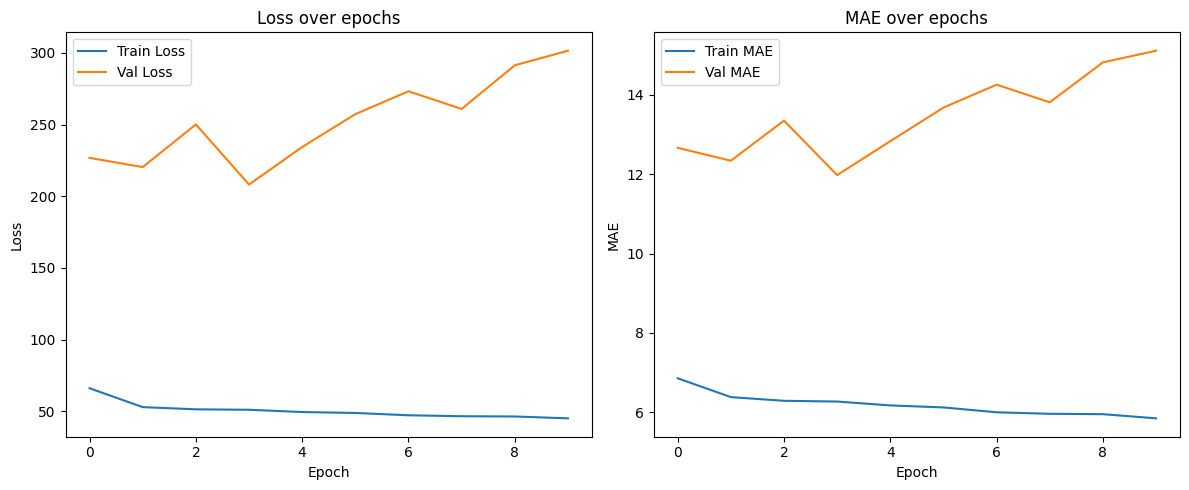

In [23]:
plot_training_history(train_history, val_history)

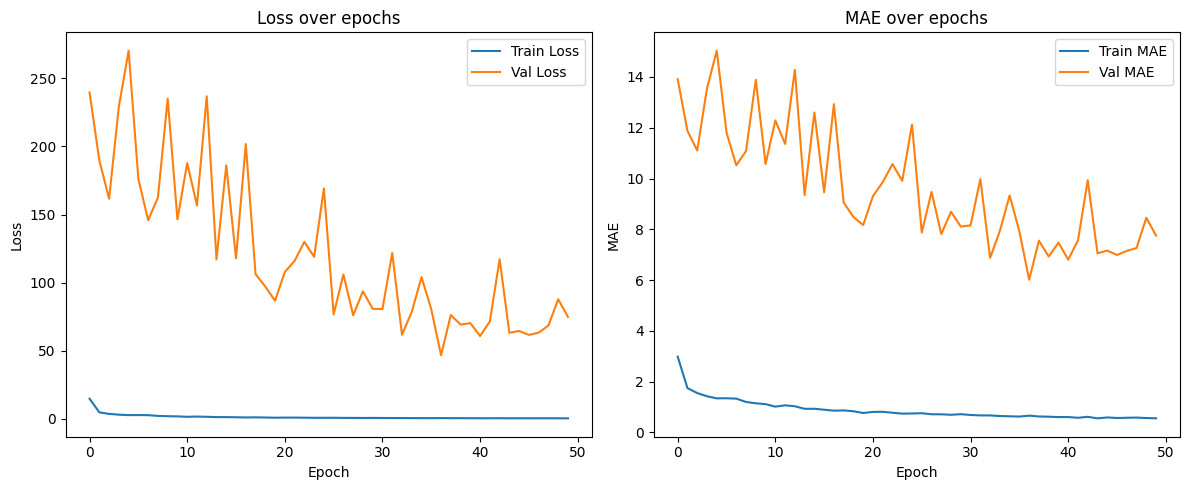

In [24]:
plot_training_history(train_history_finetune, val_history_finetune)

## Test the model

Evaluate the model in the test set

In [25]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


In [26]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")

In [27]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # [batch_size,1]

            outputs = model(images)
            loss = criterion(outputs, labels)

            mae = F.l1_loss(outputs, labels)  # mean absolute error

            running_loss += loss.item() * images.size(0)
            running_mae += mae.item() * images.size(0)
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_mae = running_mae / total_samples
            test_bar.set_postfix(loss=avg_loss, MAE=avg_mae)

    test_loss = running_loss / total_samples
    test_mae = running_mae / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f}")
    return test_loss, test_mae


# Exemplo de uso:

best_model_path = 'best_model.pth'  # caminho para o melhor modelo guardado

# Carrega o modelo antes do teste
load_model(model, best_model_path, device)

# Avalia no conjunto de teste
test_loss, test_acc = test_model(model, test_dataloader, loss_fn, device)

Loaded model from best_model.pth


Testing:   0%|          | 0/306 [00:00<?, ?it/s]C:\Users\diogo\AppData\Local\Temp\ipykernel_14464\2133313898.py:17: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels)  # mean absolute error
Testing: 100%|██████████| 306/306 [00:37<00:00,  8.20it/s, MAE=6.22, loss=51.3]


Test Loss: 51.3478 | Test MAE: 6.2209
